In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nrclex import NRCLex
from tqdm import tqdm
import re
import empath
import nltk

In [2]:
df = pd.read_parquet('rest_reviews_15_19.parquet')

print(df.shape)
print(df.columns)


(2754531, 5)
Index(['business_id', 'user_id', 'stars', 'text', 'date'], dtype='object')


## cleaning

In [ ]:

tqdm.pandas()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


df['clean_text'] = df['text'].progress_apply(clean_text)


100%|██████████| 2754531/2754531 [01:49<00:00, 25068.44it/s]


## downloading the punkt

In [ ]:
nltk.download('punkt')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
nltk.download('wordnet')  
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Paarth\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Paarth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Paarth\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Paarth\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Paarth\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

## Extracting Empath lexicon

In [ ]:
lexicon = empath.Empath()


categories = ['positive', 'negative', 'joy', 'sadness', 'disgust', 'anger', 'trust', 'surprise', 'anticipation']

tqdm.pandas()

def extract_empath_features(text):
    return lexicon.analyze(text, categories=categories)
df['empath_features'] = df['clean_text'].progress_apply(extract_empath_features)


100%|██████████| 2754531/2754531 [07:00<00:00, 6543.80it/s]


## Merging the empath features

In [ ]:
empath_df = df['empath_features'].apply(pd.Series)

empath_df = empath_df.add_prefix('empath_')

df = pd.concat([df, empath_df], axis=1)

df.drop(columns=['empath_features'], inplace=True)

print(df.head())


              business_id                 user_id  stars  \
0  XQfwVwDr-v0ZS3_CbbE5Xw  mh_-eMZ6K5RLWhZyISBhwA    3.0   
1  kxX2SOes4o-D3ZQBkiMRfA  _7bHUi9Uuf5__HHc_Q8guQ    5.0   
2  e4Vwtrqf-wpJfwesgvdgxQ  bcjbaE6dDog4jkNY91ncLQ    4.0   
3  04UD14gamNjLY0IDYVhHJg  eUta8W_HdHMXPzLBBZhL1A    1.0   
4  LHSTtnW3YHCeUkRDGyJOyw  yfFzsLmaWF2d4Sr0UNbBgg    5.0   

                                                text                date  \
0  If you decide to eat here, just be aware it is... 2018-07-07 22:09:11   
1  Wow!  Yummy, different,  delicious.   Our favo... 2015-01-04 00:01:03   
2  Cute interior and owner (?) gave us tour of up... 2017-01-14 20:54:15   
3  I am a long term frequent customer of this est... 2015-09-23 23:10:31   
4  Amazingly amazing wings and homemade bleu chee... 2015-08-07 02:29:16   

                                          clean_text  empath_positive  \
0  if you decide to eat here just be aware it is ...              0.0   
1  wow yummy different delicious our

In [ ]:
print("Columns:\n", df.columns.tolist())

print("\nShape:", df.shape)

Columns:
 ['business_id', 'user_id', 'stars', 'text', 'date', 'clean_text', 'empath_positive', 'empath_negative', 'empath_joy', 'empath_sadness', 'empath_disgust', 'empath_anger', 'empath_trust', 'empath_surprise', 'empath_anticipation']

Shape: (2754531, 15)


### converting to parqute

In [ ]:
df.to_parquet('restaurant_with_empath.parquet', index=False)

### Checking the mean values

empath_positive        0.000000
empath_negative        0.000000
empath_joy             0.034165
empath_sadness         0.076076
empath_disgust         0.026035
empath_anger           0.023088
empath_trust           0.225984
empath_surprise        0.076449
empath_anticipation    0.019164
dtype: float64


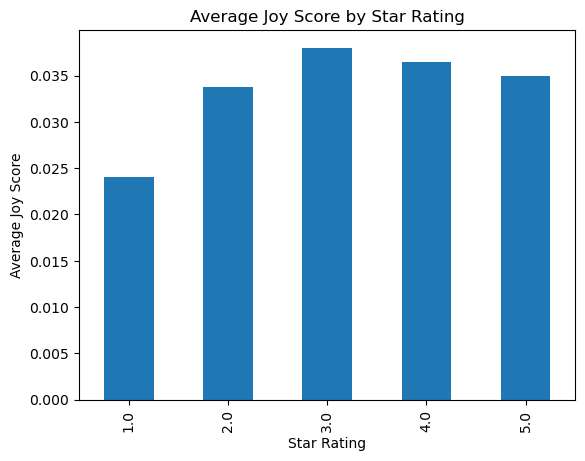

In [ ]:
print(df[[col for col in df.columns if col.startswith('empath_')]].mean())


df.groupby('stars')['empath_joy'].mean().plot(kind='bar')
plt.title('Average Joy Score by Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Average Joy Score')
plt.show()


## Extracting NRC emotion scores

In [ ]:
tqdm.pandas()
 
def extract_nrc_emotions(text):
    try:
        emotion = NRCLex(text)
        return emotion.raw_emotion_scores  
    except:
        return {}

df['nrc_emotions'] = df['clean_text'].progress_apply(extract_nrc_emotions)

100%|██████████| 2754531/2754531 [17:09<00:00, 2676.87it/s]


## Combining with main DataFrame


In [ ]:

nrc_df = df['nrc_emotions'].apply(pd.Series).fillna(0)

nrc_df = nrc_df.add_prefix('nrc_')

df = pd.concat([df, nrc_df], axis=1)
df.drop(columns=['nrc_emotions'], inplace=True)


## Check average emotion scores

nrc_positive        6.028962
nrc_anger           0.834621
nrc_disgust         0.697413
nrc_fear            0.877020
nrc_negative        1.987048
nrc_sadness         0.903427
nrc_joy             3.706973
nrc_trust           3.559639
nrc_anticipation    2.769450
nrc_surprise        1.348434
dtype: float64


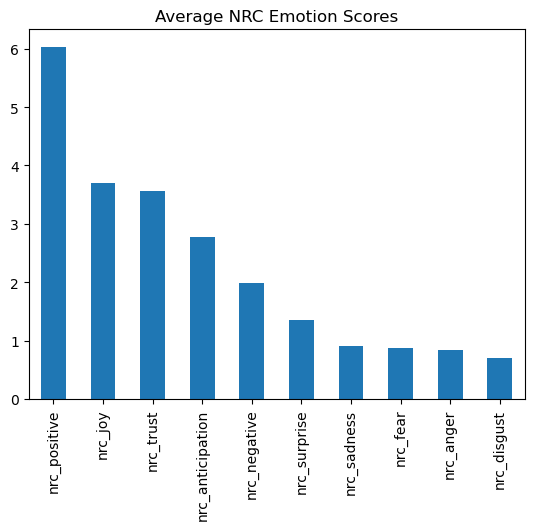

In [ ]:
print(df.filter(like='nrc_').mean())

df.filter(like='nrc_').mean().sort_values(ascending=False).plot(kind='bar', title='Average NRC Emotion Scores')
plt.show()


In [ ]:
print(df[['clean_text'] + [col for col in df.columns if col.startswith('nrc_')]].head())


                                          clean_text  nrc_positive  nrc_anger  \
0  if you decide to eat here just be aware it is ...           5.0        1.0   
1  wow yummy different delicious our favorite is ...           4.0        0.0   
2  cute interior and owner gave us tour of upcomi...           6.0        1.0   
3  i am a long term frequent customer of this est...           4.0        0.0   
4  amazingly amazing wings and homemade bleu chee...           7.0        0.0   

   nrc_disgust  nrc_fear  nrc_negative  nrc_sadness  nrc_joy  nrc_trust  \
0          1.0       1.0           2.0          1.0      4.0        3.0   
1          0.0       0.0           0.0          0.0      4.0        2.0   
2          1.0       0.0           1.0          1.0      4.0        2.0   
3          0.0       0.0           1.0          0.0      1.0        0.0   
4          0.0       0.0           1.0          0.0      4.0        3.0   

   nrc_anticipation  nrc_surprise  
0               6.0       

### Converting to parqute

In [ ]:
df.to_parquet("final_reviews_with_empath_and_nrc.parquet", index=False)

In [ ]:
print(df.head())

              business_id                 user_id  stars  \
0  XQfwVwDr-v0ZS3_CbbE5Xw  mh_-eMZ6K5RLWhZyISBhwA    3.0   
1  kxX2SOes4o-D3ZQBkiMRfA  _7bHUi9Uuf5__HHc_Q8guQ    5.0   
2  e4Vwtrqf-wpJfwesgvdgxQ  bcjbaE6dDog4jkNY91ncLQ    4.0   
3  04UD14gamNjLY0IDYVhHJg  eUta8W_HdHMXPzLBBZhL1A    1.0   
4  LHSTtnW3YHCeUkRDGyJOyw  yfFzsLmaWF2d4Sr0UNbBgg    5.0   

                                                text                date  \
0  If you decide to eat here, just be aware it is... 2018-07-07 22:09:11   
1  Wow!  Yummy, different,  delicious.   Our favo... 2015-01-04 00:01:03   
2  Cute interior and owner (?) gave us tour of up... 2017-01-14 20:54:15   
3  I am a long term frequent customer of this est... 2015-09-23 23:10:31   
4  Amazingly amazing wings and homemade bleu chee... 2015-08-07 02:29:16   

                                          clean_text  empath_positive  \
0  if you decide to eat here just be aware it is ...              0.0   
1  wow yummy different delicious our

In [ ]:
print("Columns:\n", df.columns.tolist())
print("\nShape:", df.shape)

Columns:
 ['business_id', 'user_id', 'stars', 'text', 'date', 'clean_text', 'empath_positive', 'empath_negative', 'empath_joy', 'empath_sadness', 'empath_disgust', 'empath_anger', 'empath_trust', 'empath_surprise', 'empath_anticipation', 'nrc_positive', 'nrc_anger', 'nrc_disgust', 'nrc_fear', 'nrc_negative', 'nrc_sadness', 'nrc_joy', 'nrc_trust', 'nrc_anticipation', 'nrc_surprise']

Shape: (2754531, 25)


### Checking the distribution

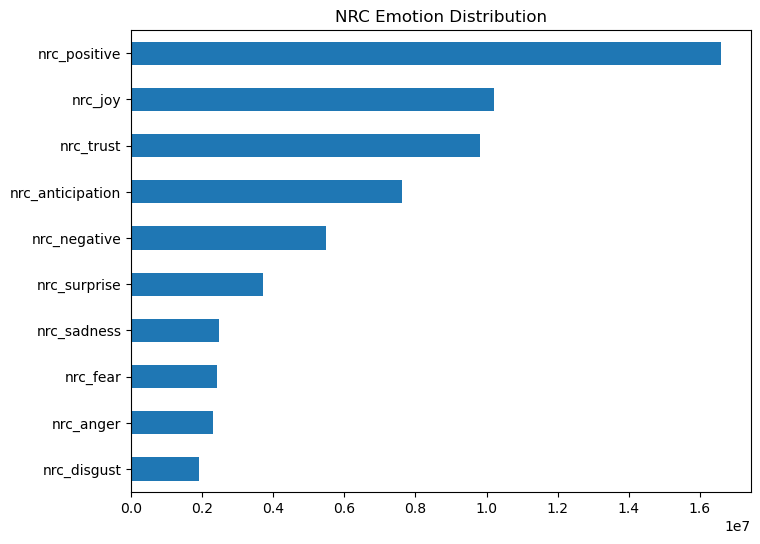

In [ ]:
nrc_cols = [col for col in df.columns if col.startswith('nrc_')]
df[nrc_cols].sum().sort_values().plot(kind='barh', figsize=(8, 6), title='NRC Emotion Distribution')
plt.show()


In [ ]:
print(df[[*nrc_cols, 'stars']].corr()['stars'].sort_values(ascending=False))


stars               1.000000
nrc_joy             0.082381
nrc_positive        0.016904
nrc_trust          -0.017052
nrc_surprise       -0.040312
nrc_anticipation   -0.068480
nrc_fear           -0.238888
nrc_anger          -0.280814
nrc_sadness        -0.299448
nrc_negative       -0.344420
nrc_disgust        -0.373928
Name: stars, dtype: float64


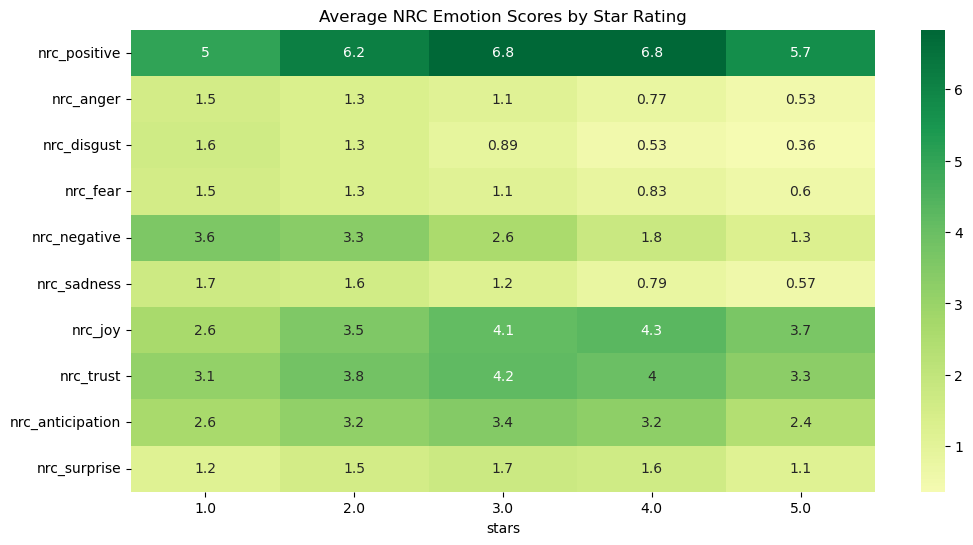

In [ ]:
emotion_cols = [col for col in df.columns if col.startswith('nrc_')]
df_grouped = df.groupby('stars')[emotion_cols].mean()

plt.figure(figsize=(12,6))
sns.heatmap(df_grouped.T, annot=True, cmap="RdYlGn", center=0)
plt.title("Average NRC Emotion Scores by Star Rating")
plt.show()


In [ ]:
df['nrc_sentiment_score'] = df['nrc_joy'] + df['nrc_positive'] - (df['nrc_negative'] + df['nrc_disgust'] + df['nrc_sadness'] + df['nrc_anger'])

In [ ]:
print(df[['stars', 'nrc_sentiment_score']].head())

   stars  nrc_sentiment_score
0    3.0                  4.0
1    5.0                  8.0
2    4.0                  6.0
3    1.0                  4.0
4    5.0                 10.0
